In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1 - Gerando uma base sintética 

In [3]:
np.random.seed(42)
n = 5000

# Variáveis contínuas
idade = np.random.normal(loc=40, scale=12, size=n)
renda = np.random.normal(loc=7000, scale=2500, size=n)
anos_experiencia = np.random.normal(loc=10, scale=5, size=n)

# Variáveis categóricas
estado_civil = np.random.choice(['Solteiro', 'Casado', 'Divorciado', 'Viúvo'], size=n, p=[0.4, 0.4, 0.15, 0.05])
nivel_educacional = np.random.choice(['Fundamental', 'Médio', 'Superior', 'Mestrado', 'Doutorado'], size=n, p=[0.2, 0.4, 0.3, 0.08, 0.02])

# Variáveis de ruído
ruido1 = np.random.normal(loc=0, scale=1, size=n)
ruido2 = np.random.normal(loc=0, scale=1, size=n)

# Target
target = (
    0.3 * idade +
    0.7 * renda +
    500 * anos_experiencia +
    np.where(estado_civil == 'Casado', 1000, 0) +
    np.where(nivel_educacional == 'Mestrado', 3000, 0) +
    np.where(nivel_educacional == 'Doutorado', 5000, 0) +
    np.random.normal(loc=0, scale=3000, size=n)
)

df = pd.DataFrame({
    'idade': idade,
    'renda': renda,
    'anos_experiencia': anos_experiencia,
    'estado_civil': estado_civil,
    'nivel_educacional': nivel_educacional,
    'ruido1': ruido1,
    'ruido2': ruido2,
    'target': target
})

# Introduzindo outliers
outlier_idx = np.random.choice(df.index, size=int(0.01 * n), replace=False)
df.loc[outlier_idx, 'renda'] *= np.random.randint(3, 6)
df.loc[outlier_idx, 'target'] *= np.random.randint(2, 4)

# Introduzindo NULOS nas quantitativas
for col in ['idade', 'renda', 'anos_experiencia']:
    missing_idx = np.random.choice(df.index, size=int(0.02 * n), replace=False)
    df.loc[missing_idx, col] = np.nan

# Introduzindo NULOS nas categóricas
for col in ['estado_civil', 'nivel_educacional']:
    missing_idx = np.random.choice(df.index, size=int(0.02 * n), replace=False)
    df.loc[missing_idx, col] = np.nan

# 2 - Separacao entre treino e teste

In [5]:
X = df.drop(columns=['target'])
y = df['target']# Separar Features e Target
X = df.drop(columns=['target'])
y = df['target']

# Dividir em treino/teste (70%/30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 3 - Tratando nulos

In [6]:
# Imputação de Quantitativas com mediana do treino
medianas = X_train[['idade', 'renda', 'anos_experiencia']].median()

for col in ['idade', 'renda', 'anos_experiencia']:
    X_train[col] = X_train[col].fillna(medianas[col])
    X_test[col] = X_test[col].fillna(medianas[col])

# Imputação de Categóricas com 'Missing'
for col in ['estado_civil', 'nivel_educacional']:
    X_train[col] = X_train[col].fillna('Missing')
    X_test[col] = X_test[col].fillna('Missing')

# 4 - Tratando variaveis categoricas com encoders

In [7]:
from sklearn.preprocessing import OneHotEncoder

# Separar variáveis categóricas e numéricas
categorical_cols = ['estado_civil', 'nivel_educacional']
numeric_cols = ['idade', 'renda', 'anos_experiencia', 'ruido1', 'ruido2']

# Ajustar One Hot Encoder apenas no treino
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

ohe.fit(X_train[categorical_cols])

# Transformar treino e teste
X_train_cat = ohe.transform(X_train[categorical_cols])
X_test_cat = ohe.transform(X_test[categorical_cols])

# Voltar os DataFrames
X_train_cat = pd.DataFrame(X_train_cat, index=X_train.index, columns=ohe.get_feature_names_out(categorical_cols))
X_test_cat = pd.DataFrame(X_test_cat, index=X_test.index, columns=ohe.get_feature_names_out(categorical_cols))

# Concatenar com as variáveis numéricas
X_train_final = pd.concat([X_train[numeric_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test[numeric_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# 5 - Utilizando Optuna para escolha dos melhores hiperparametros

In [8]:
def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = cross_val_score(
        model, X_train_final, y_train,
        scoring='neg_root_mean_squared_error',
        cv=kf
    )
    
    return -np.mean(scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print('Melhores Hiperparâmetros:', study.best_params)

[I 2025-05-04 00:45:58,252] A new study created in memory with name: no-name-65879db9-e675-462f-a0b0-eddc84444841
[I 2025-05-04 00:46:02,693] Trial 0 finished with value: 3541.7781701865415 and parameters: {'learning_rate': 0.19116674156969998, 'max_depth': 5, 'subsample': 0.7749933706677287, 'colsample_bytree': 0.5696100312346667, 'min_child_weight': 4.232167483680764, 'gamma': 2.2292487983453984, 'reg_alpha': 0.8753940976611821, 'reg_lambda': 6.541714802615625}. Best is trial 0 with value: 3541.7781701865415.
[I 2025-05-04 00:46:07,936] Trial 1 finished with value: 3823.081248384647 and parameters: {'learning_rate': 0.4744028475228721, 'max_depth': 8, 'subsample': 0.6526577467210257, 'colsample_bytree': 0.8645652185322873, 'min_child_weight': 6.076686451324453, 'gamma': 0.5229100840522499, 'reg_alpha': 0.3161505560619974, 'reg_lambda': 4.635764780224019}. Best is trial 0 with value: 3541.7781701865415.
[I 2025-05-04 00:46:12,748] Trial 2 finished with value: 3836.3337293503 and param

[I 2025-05-04 00:47:58,709] Trial 21 finished with value: 3178.5226824208466 and parameters: {'learning_rate': 0.012644306705401509, 'max_depth': 6, 'subsample': 0.7373162022843538, 'colsample_bytree': 0.6908521630778377, 'min_child_weight': 7.069932374685895, 'gamma': 1.4252081665036298, 'reg_alpha': 0.9977215194172352, 'reg_lambda': 6.4273375463206985}. Best is trial 14 with value: 3162.873437707702.
[I 2025-05-04 00:48:05,028] Trial 22 finished with value: 3373.603131661268 and parameters: {'learning_rate': 0.06665391897927023, 'max_depth': 6, 'subsample': 0.709906346683416, 'colsample_bytree': 0.7143537812682156, 'min_child_weight': 4.6046322546093945, 'gamma': 1.326055370598397, 'reg_alpha': 0.7704483748657966, 'reg_lambda': 6.793823151072747}. Best is trial 14 with value: 3162.873437707702.
[I 2025-05-04 00:48:09,237] Trial 23 finished with value: 3303.394290175545 and parameters: {'learning_rate': 0.06468946766072063, 'max_depth': 4, 'subsample': 0.8172161759419337, 'colsample_b

[I 2025-05-04 00:49:45,410] Trial 42 finished with value: 3151.273383074825 and parameters: {'learning_rate': 0.015261262165727901, 'max_depth': 4, 'subsample': 0.8114969654787033, 'colsample_bytree': 0.737288065927959, 'min_child_weight': 4.161212975814353, 'gamma': 4.985047162152679, 'reg_alpha': 0.3481758195195591, 'reg_lambda': 4.942973919236762}. Best is trial 34 with value: 3139.8109697371096.
[I 2025-05-04 00:49:49,546] Trial 43 finished with value: 3134.929891884669 and parameters: {'learning_rate': 0.010997321615839791, 'max_depth': 4, 'subsample': 0.8058837821105479, 'colsample_bytree': 0.6956327902583311, 'min_child_weight': 5.839963666891325, 'gamma': 4.94023346470483, 'reg_alpha': 0.3404289451536624, 'reg_lambda': 5.0091095409799795}. Best is trial 43 with value: 3134.929891884669.
[I 2025-05-04 00:49:53,160] Trial 44 finished with value: 3223.3697973521857 and parameters: {'learning_rate': 0.05716172701114769, 'max_depth': 3, 'subsample': 0.8150777145908671, 'colsample_by

Melhores Hiperparâmetros: {'learning_rate': 0.010893008309184493, 'max_depth': 3, 'subsample': 0.7961381548962245, 'colsample_bytree': 0.693731976033626, 'min_child_weight': 5.008424553691664, 'gamma': 4.9990946430111425, 'reg_alpha': 0.3426387331757867, 'reg_lambda': 5.652633316806263}


# 6 - Ajustando o modelo com o melhor conjunto de hiperparametros

In [9]:
best_params = study.best_params
best_params['n_estimators'] = 1000
best_params['random_state'] = 42
best_params['n_jobs'] = -1

final_model = xgb.XGBRegressor(**best_params)

final_model.fit(X_train_final, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.693731976033626, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=4.9990946430111425, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010893008309184493,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5.008424553691664, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

# 7 - Verificando desempenho na base de teste

In [19]:
y_pred_test = final_model.predict(X_test_final)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
mape = np.mean(np.abs((y_test - y_pred_test) / y_test))

print('\n=== Métricas no Teste Final ===')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.4f}')
print(f'MAPE: {mape:.4f}')


=== Métricas no Teste Final ===
RMSE: 3133.37
MAE: 2507.13
R²: 0.5541
MAPE: 0.4075


# 8 - Analise de residuo

In [11]:
residuals = y_test - y_pred_test
df_errors = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_test,
    'residuals': residuals
})

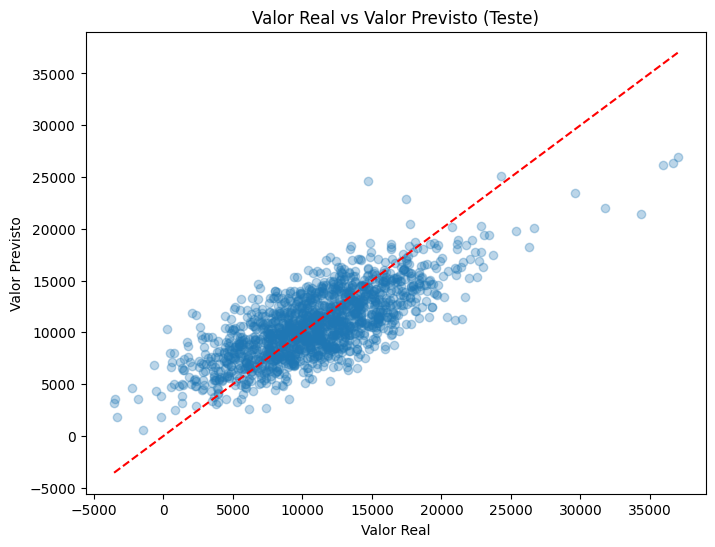

In [12]:
# Valor previsto vs valor real
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('Valor Real vs Valor Previsto (Teste)')
plt.show()

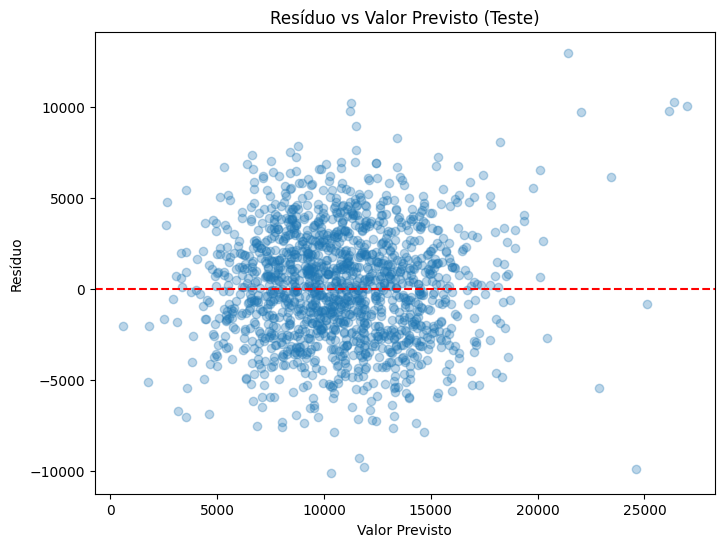

In [13]:
# Residuo vs previsao
plt.figure(figsize=(8,6))
plt.scatter(y_pred_test, residuals, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valor Previsto')
plt.ylabel('Resíduo')
plt.title('Resíduo vs Valor Previsto (Teste)')
plt.show()

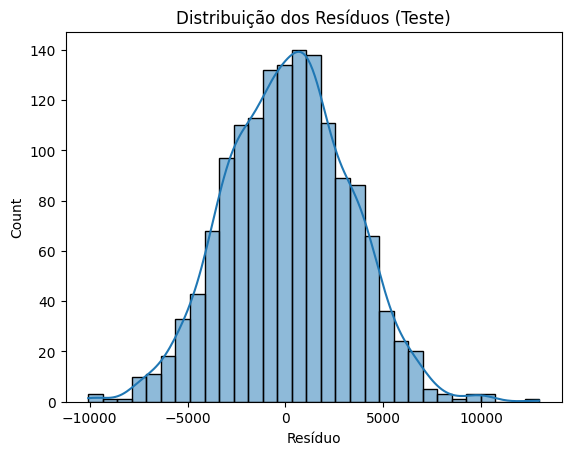

In [14]:
# Distribuicao dos residuos (verificacao da normalidade)
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos (Teste)')
plt.xlabel('Resíduo')
plt.show()

In [20]:
# Erro por Faixa de Target
bins = pd.qcut(y_test, q=8, labels=False) # Categorizamos a variavel resposta e verificamos o comportamento do erro
df_errors['bin_target'] = bins
erro_por_faixa = df_errors.groupby('bin_target')['residuals'].agg(['mean', 'median', 'std', 'count'])
print('\nErro Médio por Faixa de Target:')
print(erro_por_faixa)


Erro Médio por Faixa de Target:
                   mean       median          std  count
bin_target                                              
0          -3399.389375 -3234.292882  2239.273307    188
1          -1572.429513 -1429.485117  2189.527501    187
2           -777.969810  -839.072749  2330.205197    188
3           -349.395697  -350.242004  2198.152137    187
4            625.521337   799.886071  2356.188830    187
5           1040.456424  1027.025877  2490.168981    188
6           2207.923798  2075.271579  2421.119406    187
7           3632.794248  3589.262332  2687.800784    188


# 9 - Realizando bootstrap 

In [37]:
# Configura uma semente aleatória para reprodutibilidade
random_seed = 42
np.random.seed(random_seed)

# Número de amostras bootstrap (1000 novas bases)
n_bootstrap_samples = 1000

# Lista para armazenar as pontuações de MSE
bootstrap_mae_scores = []

# Realiza o processo de bootstrapping
for i in range(n_bootstrap_samples):
    # Gera uma amostra bootstrap (com reposição)
    bootstrap_indices = np.random.choice(len(X_test_final), size=len(X_test_final), replace=True)
    
    # Usa os índices bootstrap para selecionar os dados e converter para NumPy
    X_bootstrap = X_test_final.iloc[bootstrap_indices].values
    y_bootstrap = y_test.iloc[bootstrap_indices].values

    # Faz previsões na amostra bootstrap
    y_pred = final_model.predict(X_bootstrap)

    # Calcula o erro absoluto médio (MAE) e o armazena
    mae = mean_absolute_error(y_bootstrap, y_pred)
    bootstrap_mae_scores.append(mae)

# Estatísticas resumidas
mean_mae = np.mean(bootstrap_mae_scores)  # Média dos MAEs
std_mae = np.std(bootstrap_mae_scores)    # Desvio padrão dos MAEs

# Exibe os resultados
print(f"Resultados do Bootstrap MAE:")
print(f"Média do MAE: {mean_mae:.4f}")
print(f"Desvio padrão: {std_mae:.4f}")

Resultados do Bootstrap MAE:
Média do MAE: 2508.3287
Desvio padrão: 47.9355


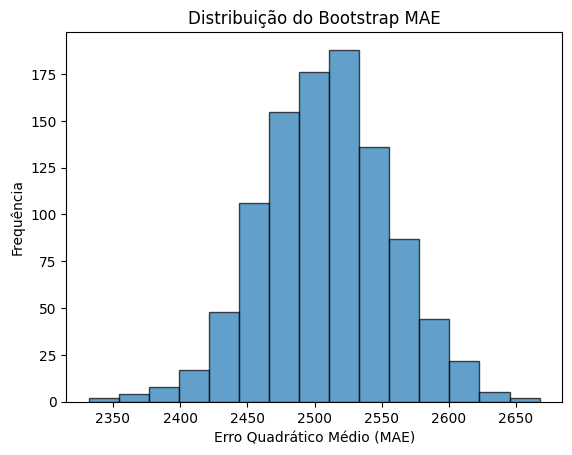

In [38]:
# Opcional: Visualizar os resultados
import matplotlib.pyplot as plt

plt.hist(bootstrap_mae_scores, bins=15, edgecolor='k', alpha=0.7)  # Cria o histograma
plt.title("Distribuição do Bootstrap MAE")  # Título do gráfico
plt.xlabel("Erro Quadrático Médio (MAE)")    # Rótulo do eixo X
plt.ylabel("Frequência")                     # Rótulo do eixo Y
plt.show()                                   # Exibe o gráfico

# 10 - Feature Importance (impacto da variavel na qualidade do erro - MAE)

In [39]:
# Configura uma semente aleatória para reprodutibilidade
random_seed = 42
np.random.seed(random_seed)

# Inicializa um contêiner para armazenar os resultados de desempenho
feature_mae = []

# Itera sobre cada feature (coluna)
for feature in X_test_final.columns:
    # Cria uma cópia de X_test
    X_test_modified = X_test_final.copy()
    
    # Substitui a feature atual por valores aleatórios
    X_test_modified[feature] = np.random.permutation(X_test_final[feature])
    
    # Avalia o modelo no conjunto de dados modificado
    y_pred = final_model.predict(X_test_modified)
    mae = mean_absolute_error(y_test, y_pred)
    feature_mae.append(mae)
    print(f"{feature} - MSE: {mae:.4f}")

idade - MSE: 2509.2447
renda - MSE: 3368.6672
anos_experiencia - MSE: 3646.7994
ruido1 - MSE: 2503.8204
ruido2 - MSE: 2503.5801
estado_civil_Casado - MSE: 2538.8723
estado_civil_Divorciado - MSE: 2509.5647
estado_civil_Missing - MSE: 2507.5807
estado_civil_Solteiro - MSE: 2507.7426
estado_civil_Viúvo - MSE: 2507.0069
nivel_educacional_Doutorado - MSE: 2568.6990
nivel_educacional_Fundamental - MSE: 2506.7111
nivel_educacional_Mestrado - MSE: 2626.0282
nivel_educacional_Missing - MSE: 2506.9860
nivel_educacional_Médio - MSE: 2508.3611
nivel_educacional_Superior - MSE: 2507.1655


# 11 - Analise do erro pelas variaveis explicativas

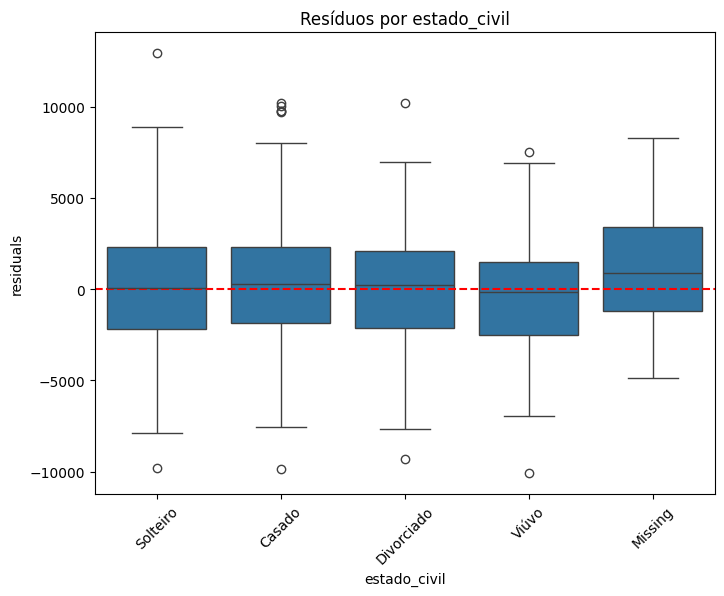


Resumo dos erros para estado_civil:

              Erro_Absoluto_Médio  Desvio_Padrão  Quantidade
estado_civil                                                
Casado                2470.949752    3049.867860         598
Divorciado            2467.223503    3157.341586         224
Missing               2420.832676    3000.695306          29
Solteiro              2576.443941    3192.517124         568
Viúvo                 2429.451624    3195.304636          81


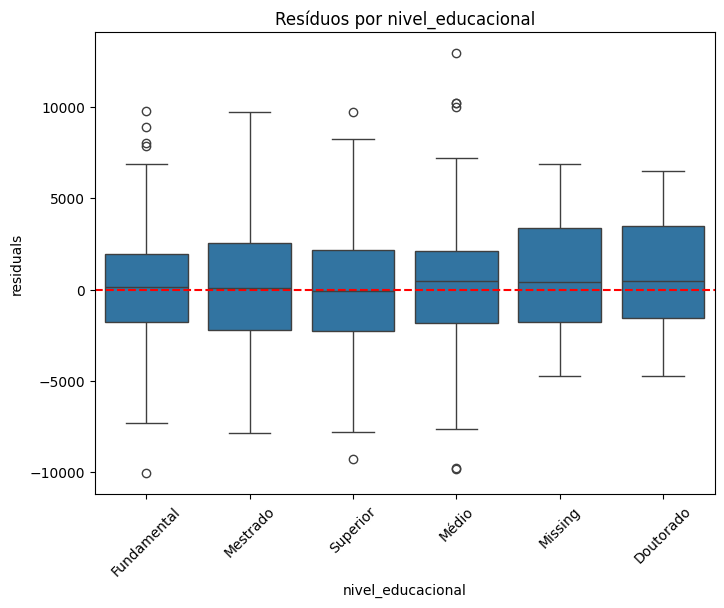


Resumo dos erros para nivel_educacional:

                   Erro_Absoluto_Médio  Desvio_Padrão  Quantidade
nivel_educacional                                                
Doutorado                  2691.764671    3202.360441          27
Fundamental                2387.882414    3040.678963         318
Mestrado                   2643.939900    3281.341084         111
Missing                    2623.574958    3138.170032          33
Médio                      2428.515638    3040.620474         563
Superior                   2636.968847    3254.139913         448


In [45]:
# Vamos recuperar as variáveis categóricas no X_test
categorical_cols = ['estado_civil', 'nivel_educacional']

# Importante: lembre que fizemos OneHotEncoding. Precisamos recuperar o X_test original
# (vou assumir que você salvou X_test antes do encoding)

X_test_segmented = X_test.copy()
X_test_segmented['residuals'] = residuals

for col in categorical_cols:
    plt.figure(figsize=(8,6))
    sns.boxplot(x=col, y='residuals', data=X_test_segmented)
    plt.title(f'Resíduos por {col}')
    plt.xticks(rotation=45)
    plt.axhline(0, color='red', linestyle='--')
    plt.show()

    grouped = X_test_segmented.groupby(col)['residuals'].agg(
        Erro_Absoluto_Médio=lambda x: np.mean(np.abs(x)),
        Desvio_Padrão='std',
        Quantidade='count'
    )

    print(f'\nResumo dos erros para {col}:\n')
    print(grouped)

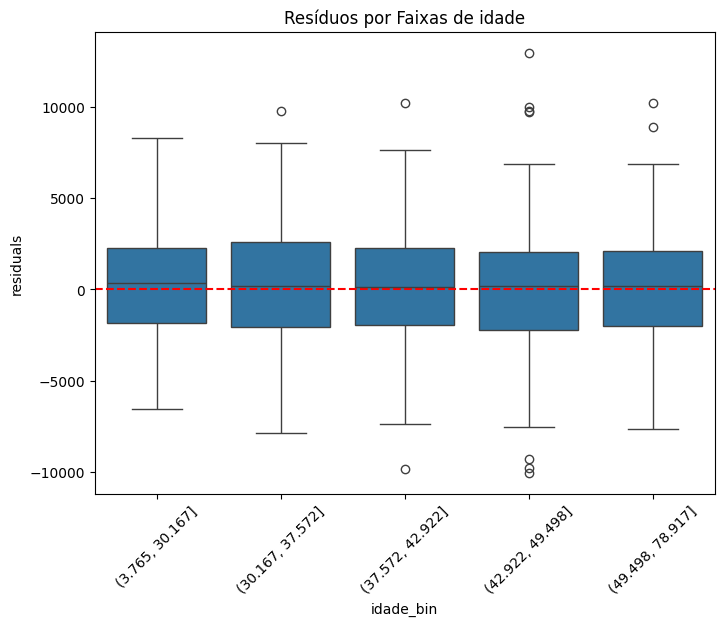


Resumo dos erros para idade:

                  Erro_Absoluto_Médio  Desvio_Padrão  Quantidade
idade_bin                                                       
(3.765, 30.167]           2412.786967    2966.297217         300
(30.167, 37.572]          2632.844505    3276.164596         300
(37.572, 42.922]          2477.424474    3093.853686         300
(42.922, 49.498]          2613.382250    3341.308199         300
(49.498, 78.917]          2399.214817    2967.179628         300


C:\Users\gcabr\AppData\Local\Temp\ipykernel_4660\3854341519.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby(col+'_bin')['residuals'].agg(


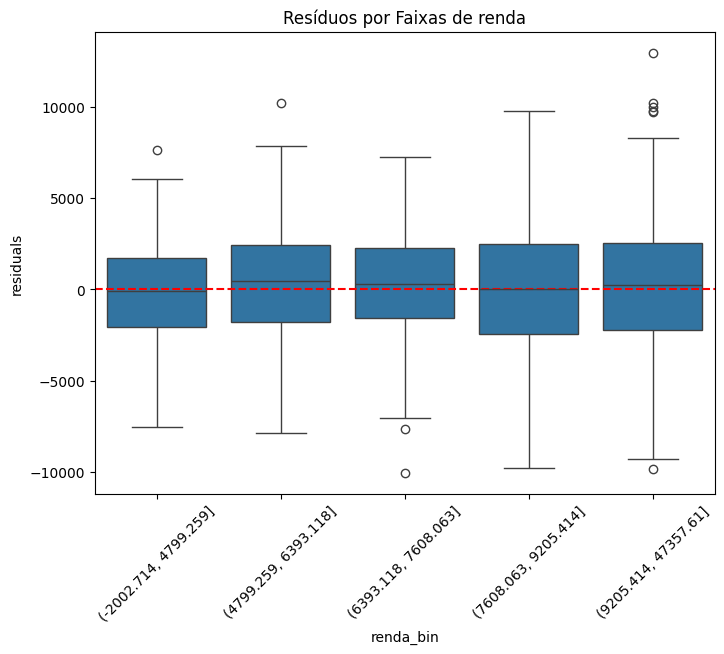

C:\Users\gcabr\AppData\Local\Temp\ipykernel_4660\3854341519.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby(col+'_bin')['residuals'].agg(



Resumo dos erros para renda:

                       Erro_Absoluto_Médio  Desvio_Padrão  Quantidade
renda_bin                                                            
(-2002.714, 4799.259]          2220.744117    2776.646556         300
(4799.259, 6393.118]           2531.194255    3130.880298         300
(6393.118, 7608.063]           2503.586096    3130.071549         300
(7608.063, 9205.414]           2585.057499    3184.885736         300
(9205.414, 47357.61]           2695.071046    3382.741673         300


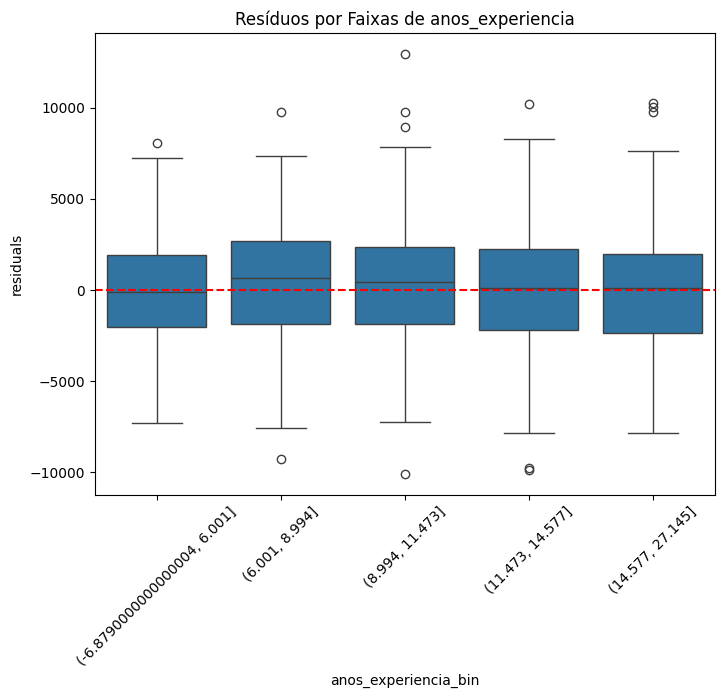


Resumo dos erros para anos_experiencia:

                              Erro_Absoluto_Médio  Desvio_Padrão  Quantidade
anos_experiencia_bin                                                        
(-6.8790000000000004, 6.001]          2347.395665    2918.617828         300
(6.001, 8.994]                        2596.319794    3158.040002         300
(8.994, 11.473]                       2517.889509    3153.997312         300
(11.473, 14.577]                      2565.977153    3221.927290         300
(14.577, 27.145]                      2508.070891    3182.057177         300


C:\Users\gcabr\AppData\Local\Temp\ipykernel_4660\3854341519.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby(col+'_bin')['residuals'].agg(


In [46]:
numeric_cols = ['idade', 'renda', 'anos_experiencia']

for col in numeric_cols:
    # Binificar a variável em faixas usando quantis
    bins = pd.qcut(X_test_segmented[col], q=5, duplicates='drop')  # 5 faixas
    
    df_temp = pd.DataFrame({
        col+'_bin': bins,
        'residuals': residuals
    })

    plt.figure(figsize=(8,6))
    sns.boxplot(x=col+'_bin', y='residuals', data=df_temp)
    plt.title(f'Resíduos por Faixas de {col}')
    plt.xticks(rotation=45)
    plt.axhline(0, color='red', linestyle='--')
    plt.show()

    grouped = df_temp.groupby(col+'_bin')['residuals'].agg(
        Erro_Absoluto_Médio=lambda x: np.mean(np.abs(x)),
        Desvio_Padrão='std',
        Quantidade='count'
    )

    print(f'\nResumo dos erros para {col}:\n')
    print(grouped)